In [1]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/mohammedalrajeh/quran-recitations-for-audio-classification")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: lachoubhanane
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/mohammedalrajeh/quran-recitations-for-audio-classification


100%|██████████| 2.12G/2.12G [00:17<00:00, 127MB/s]


In [2]:

import torch # Main PyTorch Library
from torch import nn #for creating the layers and loss function
from torch.optim import Adam # Adam Optimizer
import librosa # Library that isto read and process audio files
from torch.utils.data import Dataset, DataLoader # Dataset class and DataLoader for creating the objects
from sklearn.preprocessing import LabelEncoder # Label Encoder to encode the classes from strings to numbers
import matplotlib.pyplot as plt #for visualizing the images and plotting the training progress
import pandas as pd #to read/create dataframes (csv) and process tabular data
import numpy as np # preprocessing and numerical/mathematical operations
import os #to read the images path from the directory
import time #to calculate time for each epoch or any processing time in seconds
from skimage.transform import resize #to resize the images and we will use it to resize audio waves

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
data_df = pd.read_csv("/content/quran-recitations-for-audio-classification/files_paths.csv")
data_df['FilePath'] = '/content/quran-recitations-for-audio-classification/Dataset/' + data_df['FilePath'].str[1:]

In [7]:
data_df.head()

,FilePath,Class
0,/content/quran-recitations-for-audio-classific...,Mohammed_Aluhaidan
1,/content/quran-recitations-for-audio-classific...,Mohammed_Aluhaidan
2,/content/quran-recitations-for-audio-classific...,Mohammed_Aluhaidan
3,/content/quran-recitations-for-audio-classific...,Mohammed_Aluhaidan
4,/content/quran-recitations-for-audio-classific...,Mohammed_Aluhaidan


Data Shape is:  (6687, 2)

Claases Distrubution is: 


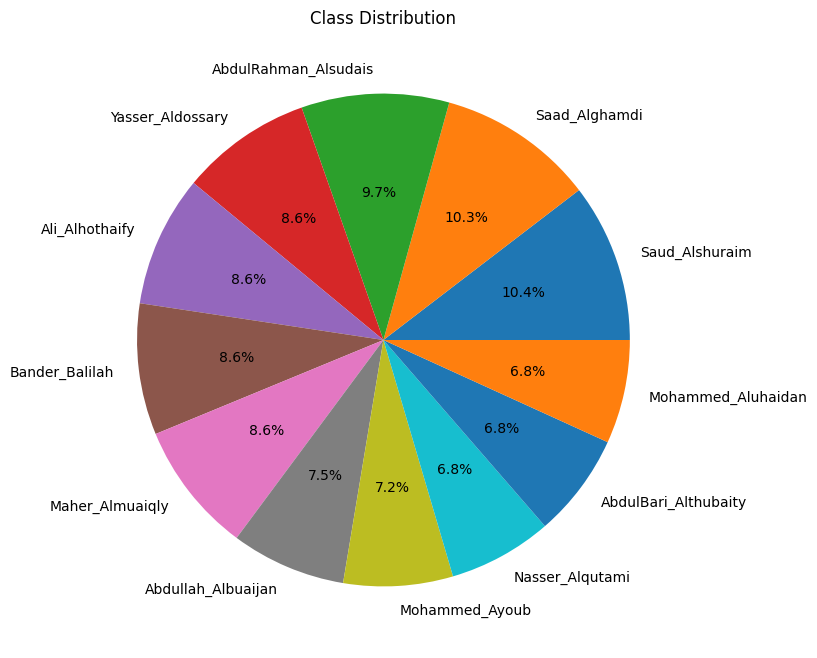

In [8]:
print("Data Shape is: ", data_df.shape)


print()
print("Claases Distrubution is: ")

class_counts = data_df['Class'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%') #add % inside the circle
plt.title('Class Distribution')

plt.show()

In [9]:
label_encoder = LabelEncoder()
data_df["Class"] = label_encoder.fit_transform(data_df["Class"])

In [10]:
from sklearn.model_selection import train_test_split
train, temp = train_test_split(
    data_df,
    test_size=0.3,
    random_state=7,
    stratify=data_df["Class"]
)

#  Split temp into validation (15%) and test (15%)
val, test = train_test_split(
    temp,
    test_size=0.5,
    random_state=7,
    stratify=temp["Class"]
)

print("Training Shape:", train.shape)
print("Validation Shape:", val.shape)
print("Testing Shape:", test.shape)

Training Shape: (4680, 2)
Validation Shape: (1003, 2)
Testing Shape: (1004, 2)


Take an audio file path.

Load exactly 5 seconds of it at 22,050 Hz.

Convert to a Mel-spectrogram.

Convert to decibels.

Resize to (128, 256) image.

Store as a tensor for the model.

In [11]:
class CustomAudioDataset(Dataset):
  def __init__(self, dataframe):
    self.dataframe = dataframe
    self.labels = torch.Tensor(list(dataframe["Class"])).type(torch.LongTensor).to(device)
    self.audios = [torch.Tensor(self.get_spectrogram(path)).type(torch.FloatTensor) for path in dataframe['FilePath']]

  def __len__(self):
    return self.dataframe.shape[0]

  def __getitem__(self, idx):
    img_path = self.dataframe.iloc[idx, 0]
    label = torch.Tensor(self.labels[idx]).to(device)
    audio = (self.audios[idx]).unsqueeze(0).to(device)
    return audio, label

  def get_spectrogram(self, file_path):
    sr = 22050 # Set the sample rate of the audio file
    duration = 5 # Set the duration of the audio files

    # Set the size of the spectrogram images
    img_height = 128
    img_width = 256

    # Load the audio file
    signal, sr = librosa.load(file_path, sr=22050, duration=duration)

    # Compute the spectrogram
    spec = librosa.feature.melspectrogram(y=signal, sr=sr, n_fft=2048, hop_length=512, n_mels=128)

    # Convert the spectrogram to dB scale
    spec_db = librosa.power_to_db(spec, ref=np.max)

    # Resize the spectrogram to the desired shape
    spec_resized = librosa.util.fix_length(spec_db, size = duration * sr // 512 + 1)
    spec_resized = resize(spec_resized, (img_height, img_width), anti_aliasing=True)
    return spec_resized

In [12]:
train_dataset = CustomAudioDataset(dataframe=train)
val_dataset = CustomAudioDataset(dataframe=val)
test_dataset = CustomAudioDataset(dataframe=test)

In [13]:
LR = 1e-4
BATCH_SIZE = 16
EPOCHS = 25

In [14]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(1, 16, kernel_size = 3, padding = 1) # First Convolution layer
    self.conv2 = nn.Conv2d(16, 32, kernel_size = 3, stride = 1, padding = 1) # Second Convolution layer
    self.conv3 = nn.Conv2d(32, 64, kernel_size = 3, stride = 1, padding = 1) # Third Convolution layer
    self.pooling = nn.MaxPool2d(2,2) # The pooling layer, we will be using the same layer after each conv2d.
    self.relu = nn.ReLU() # ReLU Activation function

    self.flatten = nn.Flatten() # Flatten and vectorize the output feature maps that somes from the final convolution layer.
    self.linear1 = nn.Linear((64 * 16 * 32), 4096) # Traditional Dense (Linear)
    self.linear2 = nn.Linear(4096, 1024) # Traditional Dense (Linear)
    self.linear4 = nn.Linear(1024, 512) # Traditional Dense (Linear)
    self.output = nn.Linear(512, len(data_df['Class'].unique())) # Output Linear Layer

    self.dropout = nn.Dropout(0.5)

  def forward(self, x):
    x = self.conv1(x) # -> Outputs: (16, (128, 256))
    x = self.pooling(x)# -> Outputs: (16, (64, 128))
    x = self.relu(x)
    x = self.dropout(x)
    x = self.conv2(x) # -> Outputs: (32, (64, 128))
    x = self.pooling(x) # -> Outputs: (32, (32, 64))
    x = self.relu(x)
    x = self.dropout(x)
    x = self.conv3(x) # -> Outputs: (64, (32, 64))
    x = self.pooling(x) # -> Outputs: (64, (16, 32))
    x = self.relu(x)
    x = self.dropout(x)
    x = x.view(x.size(0), -1)

    x = self.flatten(x)

    x = self.linear1(x)
    x = self.dropout(x)

    x = self.linear2(x)
    x = self.dropout(x)
    x = self.linear4(x)
    x = self.dropout(x)

    x = self.output(x)

    return x

model = Net().to(device)

print(model)

Net(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=32768, out_features=4096, bias=True)
  (linear2): Linear(in_features=4096, out_features=1024, bias=True)
  (linear4): Linear(in_features=1024, out_features=512, bias=True)
  (output): Linear(in_features=512, out_features=12, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


params = (kernel_height × kernel_width × in_channels × out_channels) + out_channels

In [16]:
from torchsummary import summary
summary(model, (1, 128, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 256]             160
         MaxPool2d-2          [-1, 16, 64, 128]               0
              ReLU-3          [-1, 16, 64, 128]               0
           Dropout-4          [-1, 16, 64, 128]               0
            Conv2d-5          [-1, 32, 64, 128]           4,640
         MaxPool2d-6           [-1, 32, 32, 64]               0
              ReLU-7           [-1, 32, 32, 64]               0
           Dropout-8           [-1, 32, 32, 64]               0
            Conv2d-9           [-1, 64, 32, 64]          18,496
        MaxPool2d-10           [-1, 64, 16, 32]               0
             ReLU-11           [-1, 64, 16, 32]               0
          Dropout-12           [-1, 64, 16, 32]               0
          Flatten-13                [-1, 32768]               0
           Linear-14                 [-

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LR)

In [18]:
total_loss_train_plot = [] # Empty list to be filled with train loss after each epoch
total_loss_validation_plot = [] # Empty list to be filled with validation loss after each epoch
total_acc_train_plot = [] # Empty list to be filled with train accuracy after each epoch
total_acc_validation_plot = [] # Empty list to be filled with validation accuracy after each epoch


for epoch in range(EPOCHS):
  start_time = time.time() # We use this to calculate the time of each epoch, it starts a counter once called
  total_acc_train = 0
  total_loss_train = 0
  total_loss_val = 0
  total_acc_val = 0

  for inputs, labels in train_loader:
    outputs = model(inputs)
    train_loss = criterion(outputs, labels)
    total_loss_train += train_loss.item()
    train_loss.backward()

    train_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
    total_acc_train += train_acc
    optimizer.step()
    optimizer.zero_grad()

  with torch.no_grad():
    for inputs, labels in val_loader:
      outputs = model(inputs)
      val_loss = criterion(outputs, labels)
      total_loss_val += val_loss.item()

      val_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
      total_acc_val += val_acc

  total_loss_train_plot.append(round(total_loss_train/1000, 4))
  total_loss_validation_plot.append(round(total_loss_val/1000, 4))
  total_acc_train_plot.append(round(total_acc_train/(train_dataset.__len__())*100, 4))
  total_acc_validation_plot.append(round(total_acc_val/(val_dataset.__len__())*100, 4))
  epoch_string = f"""
                  Epoch: {epoch+1}/{EPOCHS},
                  Train Loss: {round(total_loss_train/100, 4)},
                  Train Accuracy: {round((total_acc_train/train_dataset.__len__() * 100), 4)},
                  Validation Loss: {round(total_loss_val/100, 4)},
                  Validation Accuracy: {round((total_acc_val/val_dataset.__len__() * 100), 4)}
                  """
  print(epoch_string)
  print("="*30)


                  Epoch: 1/25, 
                  Train Loss: 19.9107, 
                  Train Accuracy: 11.2393, 
                  Validation Loss: 1.5444, 
                  Validation Accuracy: 12.2632
                  

                  Epoch: 2/25, 
                  Train Loss: 7.0909, 
                  Train Accuracy: 13.3761, 
                  Validation Loss: 1.5043, 
                  Validation Accuracy: 13.659
                  

                  Epoch: 3/25, 
                  Train Loss: 6.9175, 
                  Train Accuracy: 16.6453, 
                  Validation Loss: 1.4273, 
                  Validation Accuracy: 21.1366
                  

                  Epoch: 4/25, 
                  Train Loss: 6.2888, 
                  Train Accuracy: 25.9829, 
                  Validation Loss: 1.2357, 
                  Validation Accuracy: 33.3001
                  

                  Epoch: 5/25, 
                  Train Loss: 5.4459, 
                  Train 

In [19]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0
  for indx, (input, labels) in enumerate(test_loader):

    prediction = model(input)

    acc = (torch.argmax(prediction, axis = 1) == labels).sum().item()
    total_acc_test += acc

print(f"Accuracy Score is: {round((total_acc_test/test_dataset.__len__())*100, 2)}%")

Accuracy Score is: 89.94%


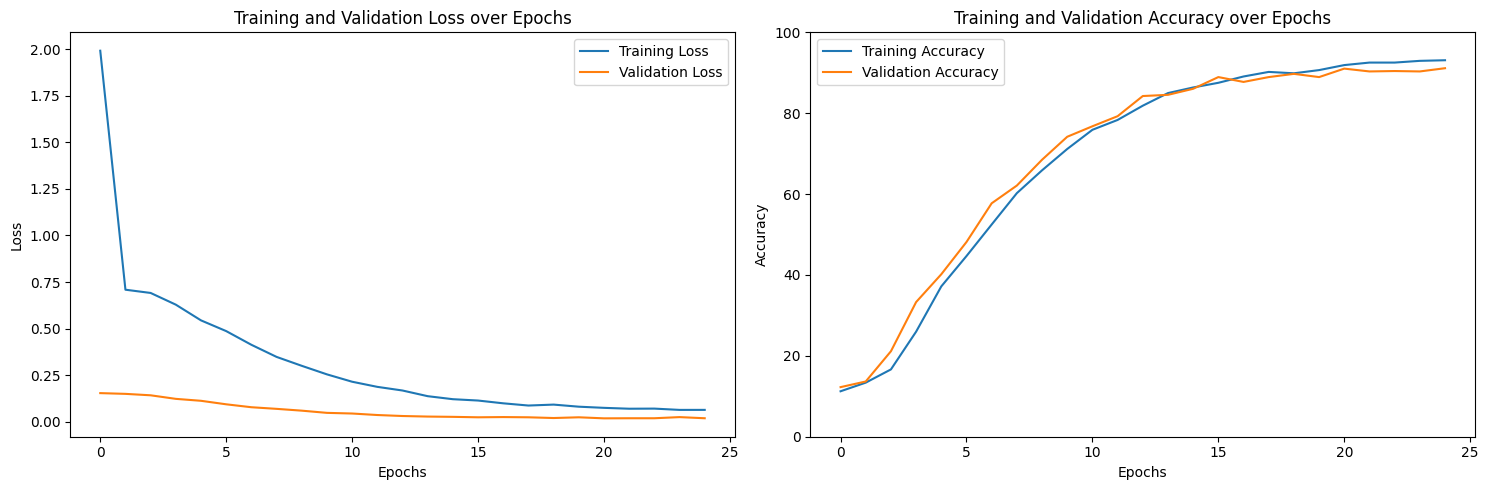

In [20]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].plot(total_loss_validation_plot, label='Validation Loss')
axs[0].set_title('Training and Validation Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[1].set_ylim([0, 2])
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].plot(total_acc_validation_plot, label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_ylim([0, 100])
axs[1].legend()

plt.tight_layout()

plt.show()


In [21]:
def preprocess_single_audio(file_path, sr=22050, duration=5, img_height=128, img_width=256):
    """
    Preprocess a single audio file for prediction
    """
    try:
        # Load the audio file
        signal, sr = librosa.load(file_path, sr=sr, duration=duration)

        # Compute the spectrogram
        spec = librosa.feature.melspectrogram(y=signal, sr=sr, n_fft=2048, hop_length=512, n_mels=128)

        # Convert the spectrogram to dB scale
        spec_db = librosa.power_to_db(spec, ref=np.max)

        # Resize the spectrogram to the desired shape
        spec_resized = librosa.util.fix_length(spec_db, size = duration * sr // 512 + 1)
        spec_resized = resize(spec_resized, (img_height, img_width), anti_aliasing=True)

        # Convert to tensor and add batch dimension
        tensor = torch.Tensor(spec_resized).unsqueeze(0).unsqueeze(0).to(device)  # Shape: (1, 1, 128, 256)

        return tensor
    except Exception as e:
        print(f"Error processing audio file: {e}")
        return None

In [22]:
def predict_single_audio(model, file_path, label_encoder):
    """
    Make prediction on a single audio file
    """
    # Preprocess the audio
    audio_tensor = preprocess_single_audio(file_path)

    if audio_tensor is None:
        return None, None, None

    # Set model to evaluation mode
    model.eval()

    with torch.no_grad():
        # Make prediction
        outputs = model(audio_tensor)

        # Get probabilities using softmax
        probabilities = torch.nn.functional.softmax(outputs, dim=1)

        # Get predicted class and confidence
        predicted_class_idx = torch.argmax(outputs, dim=1).item()
        confidence = probabilities[0][predicted_class_idx].item()

        # Convert back to original class name
        predicted_class_name = label_encoder.inverse_transform([predicted_class_idx])[0]

        return predicted_class_name, confidence, probabilities[0].cpu().numpy()


In [23]:
def predict_batch_audio(model, file_paths, label_encoder):
    """
    Make predictions on multiple audio files
    """
    predictions = []

    for file_path in file_paths:
        pred_class, confidence, probs = predict_single_audio(model, file_path, label_encoder)
        predictions.append({
            'file_path': file_path,
            'predicted_class': pred_class,
            'confidence': confidence,
            'probabilities': probs
        })

    return predictions

In [24]:
def display_prediction_results(predictions, label_encoder, top_k=3):
    """
    Display prediction results in a nice format
    """
    class_names = label_encoder.classes_

    for i, pred in enumerate(predictions):
        print(f"\n{'='*50}")
        print(f"File {i+1}: {os.path.basename(pred['file_path'])}")
        print(f"{'='*50}")
        print(f"Predicted Class: {pred['predicted_class']}")
        print(f"Confidence: {pred['confidence']:.4f} ({pred['confidence']*100:.2f}%)")

        # Show top-k predictions
        if pred['probabilities'] is not None:
            print(f"\nTop {top_k} predictions:")
            prob_indices = np.argsort(pred['probabilities'])[::-1][:top_k]
            for j, idx in enumerate(prob_indices):
                class_name = class_names[idx]
                probability = pred['probabilities'][idx]
                print(f"  {j+1}. {class_name}: {probability:.4f} ({probability*100:.2f}%)")


In [25]:
print("Making prediction on a single file...")
sample_file = test_dataset.dataframe.iloc[0]['FilePath']  # Use first test file as example
pred_class, confidence, probs = predict_single_audio(model, sample_file, label_encoder)

if pred_class is not None:
    print(f"File: {os.path.basename(sample_file)}")
    print(f"Predicted Reciter: {pred_class}")
    print(f"Confidence: {confidence:.4f} ({confidence*100:.2f}%)")

Making prediction on a single file...
File: sudais_noiseRed_074.wav
Predicted Reciter: AbdulRahman_Alsudais
Confidence: 0.9988 (99.88%)


In [26]:
print("\n" + "="*60)
print("Making predictions on multiple files...")
sample_files = test_dataset.dataframe['FilePath'].head(5).tolist()  # First 5 test files
batch_predictions = predict_batch_audio(model, sample_files, label_encoder)
display_prediction_results(batch_predictions, label_encoder)


Making predictions on multiple files...

File 1: sudais_noiseRed_074.wav
Predicted Class: AbdulRahman_Alsudais
Confidence: 0.9988 (99.88%)

Top 3 predictions:
  1. AbdulRahman_Alsudais: 0.9988 (99.88%)
  2. Bander_Balilah: 0.0012 (0.12%)
  3. Yasser_Aldossary: 0.0000 (0.00%)

File 2: Maher_377.wav
Predicted Class: Maher_Almuaiqly
Confidence: 0.9985 (99.85%)

Top 3 predictions:
  1. Maher_Almuaiqly: 0.9985 (99.85%)
  2. Saad_Alghamdi: 0.0011 (0.11%)
  3. Abdullah_Albuaijan: 0.0002 (0.02%)

File 3: Saud_020.wav
Predicted Class: Saud_Alshuraim
Confidence: 0.9693 (96.93%)

Top 3 predictions:
  1. Saud_Alshuraim: 0.9693 (96.93%)
  2. Nasser_Alqutami: 0.0106 (1.06%)
  3. Bander_Balilah: 0.0078 (0.78%)

File 4: alshuraim_052.wav
Predicted Class: Saud_Alshuraim
Confidence: 0.9986 (99.86%)

Top 3 predictions:
  1. Saud_Alshuraim: 0.9986 (99.86%)
  2. Bander_Balilah: 0.0009 (0.09%)
  3. Yasser_Aldossary: 0.0001 (0.01%)

File 5: alshuraim_097.wav
Predicted Class: Saud_Alshuraim
Confidence: 0.998

In [27]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def evaluate_model_detailed(model, test_loader, label_encoder):
    """
    Detailed evaluation of the model with confusion matrix and classification report
    """
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            predictions = torch.argmax(outputs, dim=1)

            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Create confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Print classification report
    print("\nClassification Report:")
    print("="*50)
    print(classification_report(all_labels, all_predictions,
                              target_names=label_encoder.classes_))

    return all_predictions, all_labels


Detailed Model Evaluation


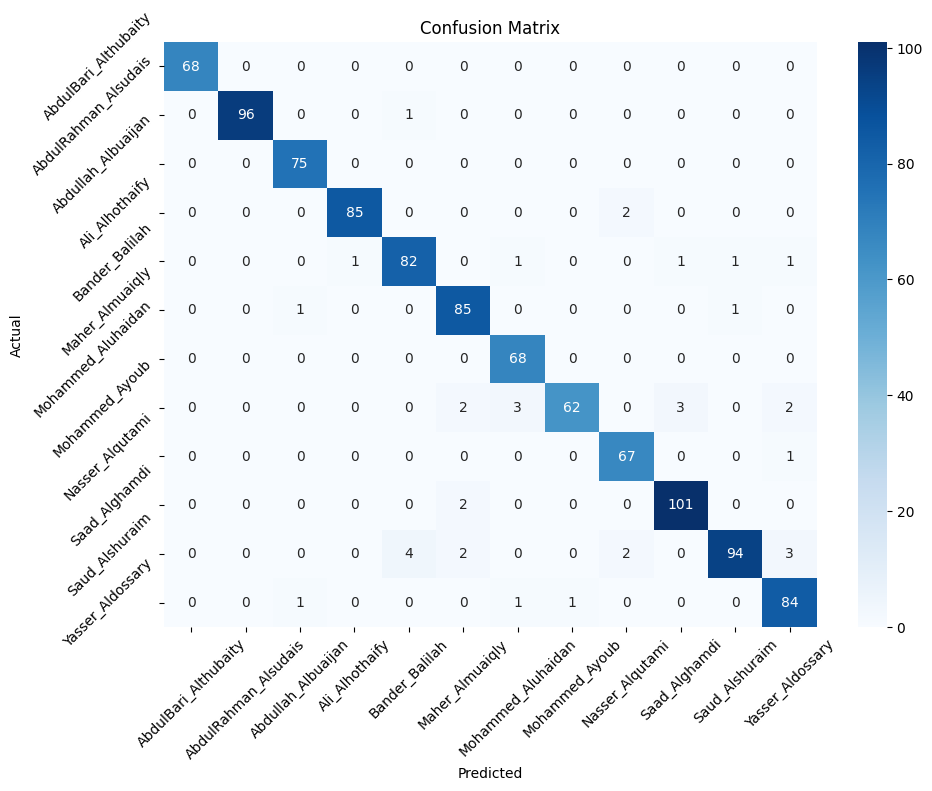


Classification Report:
                      precision    recall  f1-score   support

AbdulBari_Althubaity       1.00      1.00      1.00        68
AbdulRahman_Alsudais       1.00      0.99      0.99        97
  Abdullah_Albuaijan       0.97      1.00      0.99        75
      Ali_Alhothaify       0.99      0.98      0.98        87
      Bander_Balilah       0.94      0.94      0.94        87
     Maher_Almuaiqly       0.93      0.98      0.96        87
  Mohammed_Aluhaidan       0.93      1.00      0.96        68
      Mohammed_Ayoub       0.98      0.86      0.92        72
     Nasser_Alqutami       0.94      0.99      0.96        68
       Saad_Alghamdi       0.96      0.98      0.97       103
      Saud_Alshuraim       0.98      0.90      0.94       105
    Yasser_Aldossary       0.92      0.97      0.94        87

            accuracy                           0.96      1004
           macro avg       0.96      0.96      0.96      1004
        weighted avg       0.96      0.96   

In [28]:
print("\n" + "="*60)
print("Detailed Model Evaluation")
print("="*60)
predictions, true_labels = evaluate_model_detailed(model, test_loader, label_encoder)


In [29]:
def save_model_and_encoder(model, label_encoder, model_path='quran_reciter_model.pth', encoder_path='label_encoder.pkl'):
    """
    Save the trained model and label encoder
    """
    import pickle

    # Save model
    torch.save(model.state_dict(), model_path)
    print(f"Model saved to {model_path}")

    # Save label encoder
    with open(encoder_path, 'wb') as f:
        pickle.dump(label_encoder, f)
    print(f"Label encoder saved to {encoder_path}")


In [30]:
def load_model_and_encoder(model_path='quran_reciter_model.pth', encoder_path='label_encoder.pkl'):
    """
    Load the trained model and label encoder
    """
    import pickle

    # Load label encoder first to get number of classes
    with open(encoder_path, 'rb') as f:
        label_encoder = pickle.load(f)

    # Create model instance
    model = Net().to(device)

    # Load model weights
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    print(f"Model loaded from {model_path}")
    print(f"Label encoder loaded from {encoder_path}")

    return model, label_encoder

# Save the current model and encoder
save_model_and_encoder(model, label_encoder)


Model saved to quran_reciter_model.pth
Label encoder saved to label_encoder.pkl


In [31]:
def predict_new_audio(file_path, model_path='quran_reciter_model.pth', encoder_path='label_encoder.pkl'):
    """
    Load model and make prediction on a completely new audio file
    """
    # Load model and encoder
    model, label_encoder = load_model_and_encoder(model_path, encoder_path)

    # Make prediction
    pred_class, confidence, probs = predict_single_audio(model, file_path, label_encoder)

    if pred_class is not None:
        print(f"Audio File: {os.path.basename(file_path)}")
        print(f"Predicted Reciter: {pred_class}")
        print(f"Confidence: {confidence:.4f} ({confidence*100:.2f}%)")

        # Show top 3 predictions
        class_names = label_encoder.classes_
        prob_indices = np.argsort(probs)[::-1][:3]
        print("\nTop 3 predictions:")
        for i, idx in enumerate(prob_indices):
            print(f"  {i+1}. {class_names[idx]}: {probs[idx]:.4f} ({probs[idx]*100:.2f}%)")

    return pred_class, confidence

In [ ]:
# to use with new file
pred_class, confidence = predict_new_audio('/path to new audio/file.wav')